In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

sys.path.append('/user_data/mmhender/featsynth/')
from code_utils import stats_utils, plot_utils

In [2]:
stats_utils

<module 'code_utils.stats_utils' from '/user_data/mmhender/featsynth/code_utils/stats_utils.py'>

In [3]:
project_root = '/user_data/mmhender/featsynth/'

expt_name = 'expt1'

data_folder = os.path.join(project_root, 'online_data', expt_name)
expt_design_folder = os.path.join(project_root, 'expt_design', expt_name)
preproc_folder = os.path.join(data_folder, 'preproc')

In [20]:
data_filename = os.path.join(preproc_folder, 'preproc_data_all.csv')
trial_data_all = pd.read_csv(data_filename)
subjects = np.unique(trial_data_all['subject'])
n_subjects = len(subjects)
subject_cb = np.array([np.array(trial_data_all['which_cb'])[trial_data_all['subject']==si][0] \
              for si in subjects])
subject_rndorder = np.array([np.array(trial_data_all['random_order_number'])[trial_data_all['subject']==si][0] \
              for si in subjects])
subject_ppd = np.array([np.array(trial_data_all['pixels_per_degree'])[trial_data_all['subject']==si][0] \
              for si in subjects])
subjects, subject_cb, subject_rndorder, subject_ppd

(array([1, 2, 3, 4, 5, 6, 7]),
 array([1, 1, 1, 2, 1, 2, 1]),
 array([29, 42, 18, 19,  7, 77,  5]),
 array([33.73730906, 30.        , 38.51238362, 42.39797792, 40.48692956,
        23.30091422, 36.28067326]))

In [22]:
super_names_eachset = []
basic_names_eachset = []

for which_cb in [1,2]:
    info_filename = os.path.join(expt_design_folder, 'trial_info_counterbal%d_randorder0.csv'%which_cb)
    info = pd.read_csv(info_filename)
    
    super_names = np.unique(info['super_name'])
    basic_names = []
    for sup in super_names:
        basic = np.unique(np.array(info['basic_name'][info['super_name']==sup]))
        basic_names += [basic]
        
    super_names_eachset += [super_names]    
    basic_names_eachset += [basic_names]
    
n_supcat = len(super_names_eachset[0])
n_bascat = len(basic_names_eachset[0][0])
n_supcat, n_bascat

(10, 10)

In [23]:
cue_level_vals = np.unique(info['cue_level'])
n_cue_levels = len(cue_level_vals)

image_type_vals = np.unique(info['image_type_num'])
n_image_types = len(image_type_vals)

acc_by_condition = np.zeros((n_subjects, n_cue_levels, n_image_types))
dprime_by_condition = np.zeros((n_subjects, n_cue_levels, n_image_types))
propyes_by_condition = np.zeros((n_subjects, n_cue_levels, n_image_types))
overall_acc = np.zeros((n_subjects,))

acc_by_supcat = [np.zeros((np.sum(subject_cb==cb), n_cue_levels, n_image_types, n_supcat)) \
                 for cb in [1,2]]
cb_sub_count = [0,0]

run_nums = np.unique(trial_data_all['run_number'])
n_runs = len(run_nums)
acc_by_run = np.zeros((n_subjects, n_runs))
acc_by_run_goodonly = np.zeros((n_subjects, n_runs))
rt_by_run = np.zeros((n_subjects, n_runs))

for si, ss in enumerate(subjects):
    
    trial_data = trial_data_all[trial_data_all['subject']==ss]
   
    overall_acc[si] = np.mean(trial_data['correct'])

    for ri, rr in enumerate(run_nums):
        run_inds = trial_data['run_number']==rr
        good_inds = ~np.isnan(trial_data['rt'])
        acc_by_run[si,ri] = np.mean(np.array(trial_data['correct'])[run_inds])
        acc_by_run_goodonly[si,ri] = np.mean(np.array(trial_data['correct'])[run_inds & good_inds])
        rt_by_run[si,ri] = np.nanmean(np.array(trial_data['rt'])[run_inds])
        
    if np.array(trial_data['which_cb'])[0]==1:
        cbi=0;
    else:
        cbi=1;

    supnames = super_names_eachset[cbi]
      
    for cc, cue in enumerate(cue_level_vals):

        for ii, imtype in enumerate(image_type_vals):

            inds = (trial_data['cue_level']==cue) & (trial_data['image_type_num']==imtype)

            acc_by_condition[si,cc,ii] = np.mean(np.array(trial_data['correct'])[inds])
            
            predlabs = np.array(trial_data['resp'])[inds]
            reallabs = np.array(trial_data['correct_resp'])[inds]
            
            did_respond = predlabs>-1
            
            predlabs = predlabs[did_respond]
            reallabs = reallabs[did_respond]
            
            dprime_by_condition[si,cc,ii] = stats_utils.get_dprime(predlabs, reallabs)

            propyes_by_condition[si,cc,ii] = np.mean(np.array(trial_data['resp'])[inds]==1)
            
            for sc, supcat in enumerate(supnames):
                
                inds = (trial_data['cue_level']==cue) & \
                        (trial_data['image_type_num']==imtype) & \
                        (trial_data['super_name']==supcat)
                
                acc_by_supcat[cbi][cb_sub_count[cbi],cc,ii,sc] = np.mean(np.array(trial_data['correct'])[inds])

    cb_sub_count[cbi]+=1
     

In [24]:

image_type_names = np.array(['intact', 'match pool1', 'match pool2', 'match pool3', 'match pool4'])
cue_level_names = ['cue basic', 'cue superordinate']

type_order_plot = [1,2,3,4,0]

# as quality control, check accuracy on the intact condition. subjects
# should all be above 0.50 on this since it's easy.
intact_acc = np.mean(acc_by_condition[:,:,0], axis=1)
# subjects_use = intact_acc>0.50
subjects_use = intact_acc>0.60
subjects_use

array([ True,  True,  True,  True,  True,  True,  True])

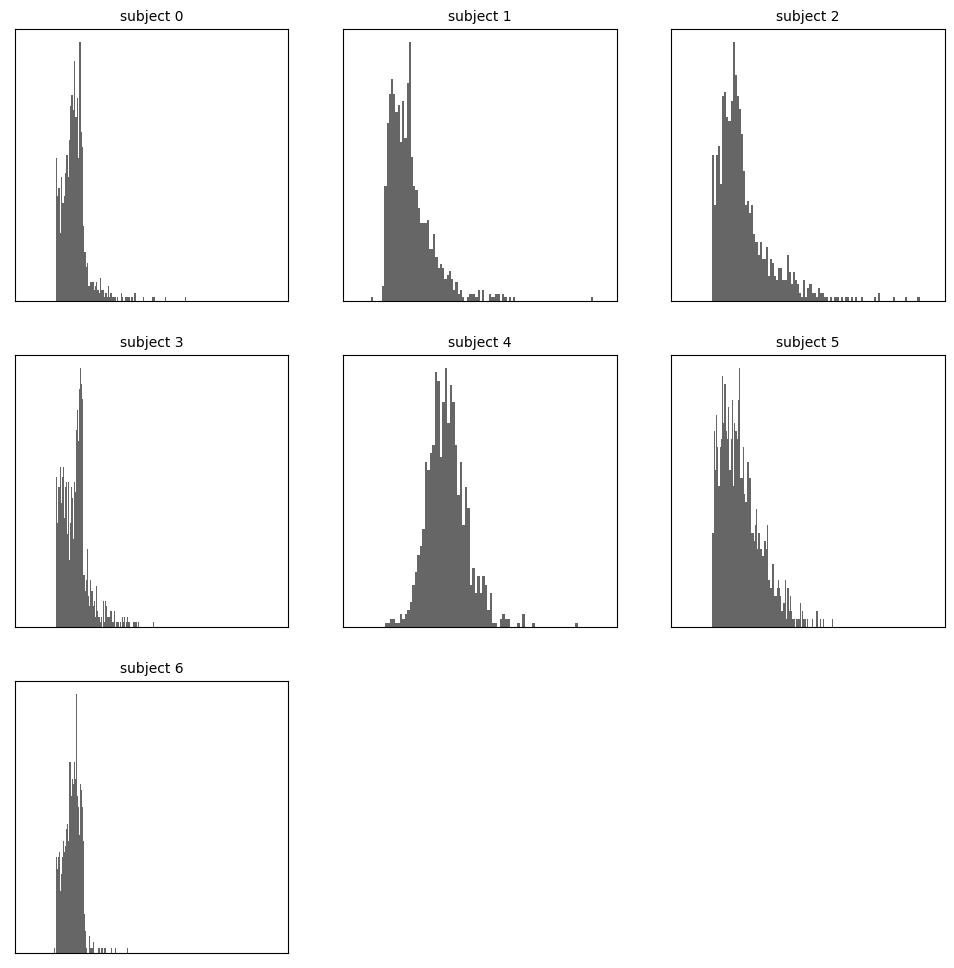

In [25]:
plt.figure(figsize=(12,12))
npy = int(np.ceil(np.sqrt(n_subjects)))
npx = int(np.ceil(n_subjects/npy))
xlims = [0, 2000]


for si,ss in enumerate(subjects):

    plt.subplot(npx, npy, si+1)
    
    rts = np.array(trial_data_all['rt'])[trial_data_all['subject']==ss]
    
    if subjects_use[si]:
        plt.hist(rts,100, color=[0.4, 0.4, 0.4]);
    else:
        plt.hist(rts,100, color=[0.8, 0.8, 0.8]);
    plt.title('subject %d'%si)
    
    plt.xlim(xlims)
    plt.xticks([])
    plt.yticks([])

In [11]:
intact_acc

array([0.935, 0.925, 0.915, 0.955, 0.915, 0.865, 0.91 ])

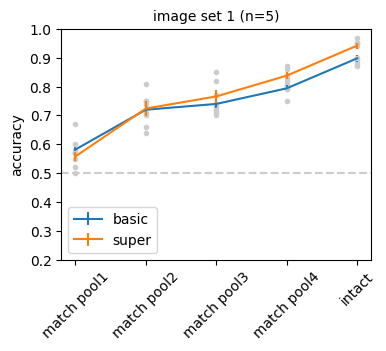

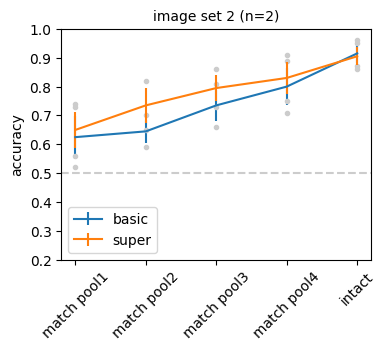

In [26]:
plot_utils.set_all_font_sizes(10)

for cb in [1,2]:

    subjects_plot = (subject_cb==cb) & subjects_use
    n_subs_plot = np.sum(subjects_plot)
    
    plt.figure(figsize=(4,3))
    ax = plt.subplot(1,1,1)

    lh = []
    for cc, cue in enumerate(cue_level_vals):

        vals = acc_by_condition[subjects_plot,cc,:]

        plt.plot(np.arange(n_image_types), vals[:,type_order_plot].T,\
                 '.',color=[0.8, 0.8, 0.8])
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)

        h = plt.errorbar(np.arange(n_image_types), meanvals[type_order_plot], semvals[type_order_plot])
        # h, = plt.plot(vals[type_order_plot], '.-')
        plt.xticks(np.arange(n_image_types), image_type_names[type_order_plot],rotation=45)
        lh.append(h)

    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, cue_level_vals)

    plt.ylabel('accuracy')

    plt.ylim([0.2, 1.0])
    
    plt.title('image set %d (n=%d)'%(cb,n_subs_plot))

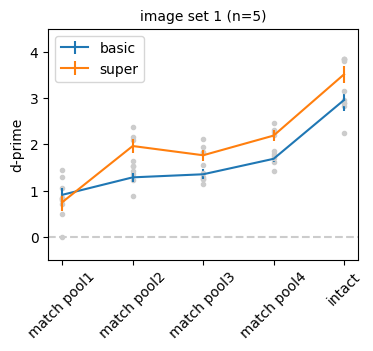

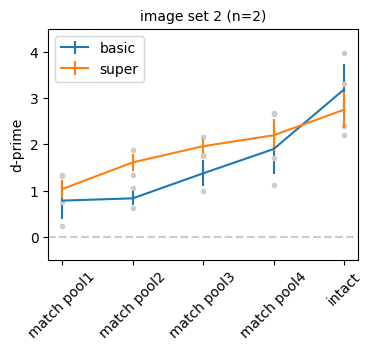

In [30]:
plot_utils.set_all_font_sizes(10)

for cb in [1,2]:

    subjects_plot = (subject_cb==cb) & subjects_use
    n_subs_plot = np.sum(subjects_plot)
    
    plt.figure(figsize=(4,3))
    ax = plt.subplot(1,1,1)

    lh = []
    for cc, cue in enumerate(cue_level_vals):

        vals = dprime_by_condition[subjects_plot,cc,:]

        plt.plot(np.arange(n_image_types), vals[:,type_order_plot].T,\
                 '.',color=[0.8, 0.8, 0.8])
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)

        h = plt.errorbar(np.arange(n_image_types), meanvals[type_order_plot], semvals[type_order_plot])
        # h, = plt.plot(vals[type_order_plot], '.-')
        plt.xticks(np.arange(n_image_types), image_type_names[type_order_plot],rotation=45)
        lh.append(h)

    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, cue_level_vals)

    plt.ylabel('d-prime')

    plt.ylim([-0.5, 4.5])
    
    plt.title('image set %d (n=%d)'%(cb,n_subs_plot))

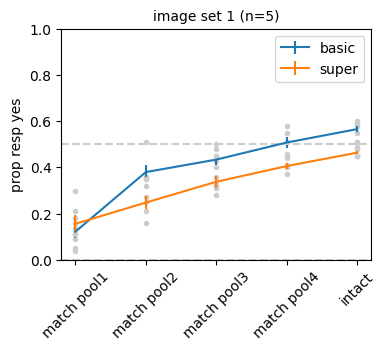

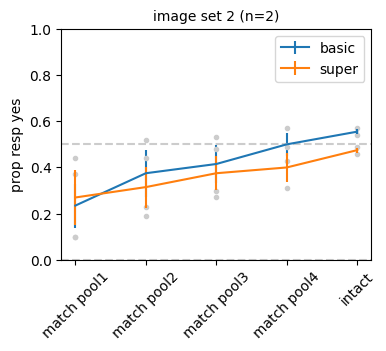

In [14]:
plot_utils.set_all_font_sizes(10)

for cb in [1,2]:

    subjects_plot = (subject_cb==cb) & subjects_use
    n_subs_plot = np.sum(subjects_plot)
    
    plt.figure(figsize=(4,3))
    ax = plt.subplot(1,1,1)

    lh = []
    for cc, cue in enumerate(cue_level_vals):

        vals = propyes_by_condition[subjects_plot,cc,:]

        plt.plot(np.arange(n_image_types), vals[:,type_order_plot].T,\
                 '.',color=[0.8, 0.8, 0.8])
        meanvals = np.mean(vals, axis=0)
        semvals = np.std(vals, axis=0)/np.sqrt(n_subs_plot)

        h = plt.errorbar(np.arange(n_image_types), meanvals[type_order_plot], semvals[type_order_plot])
        # h, = plt.plot(vals[type_order_plot], '.-')
        plt.xticks(np.arange(n_image_types), image_type_names[type_order_plot],rotation=45)
        lh.append(h)

    plt.axhline(0.0, color=[0.8, 0.8, 0.8], linestyle='--')

    ax.legend(lh, cue_level_vals)

    plt.ylabel('prop resp yes')

    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')

    plt.ylim([0, 1])
    
    plt.title('image set %d (n=%d)'%(cb,n_subs_plot))

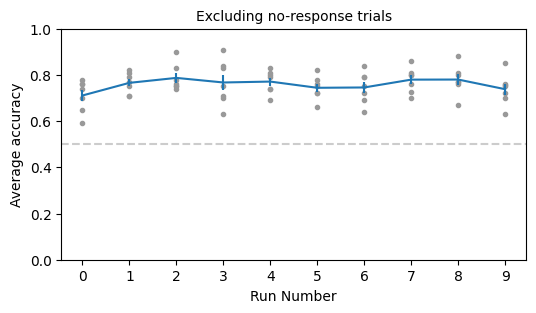

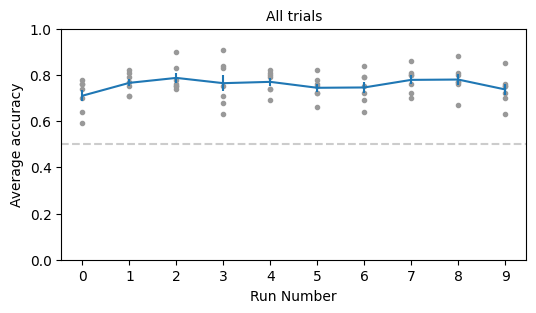

In [15]:
for plot_vals, title in zip([acc_by_run_goodonly, acc_by_run], ['Excluding no-response trials', 'All trials']):
   
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure(figsize=(6,3))

    for si in range(n_subjects):
        plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals)
    plt.xticks(np.arange(n_runs))
    plt.xlabel('Run Number')
    plt.ylabel('Average accuracy')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.ylim([0.0, 1.0])
    plt.title(title)
    

(0.0, 2000.0)

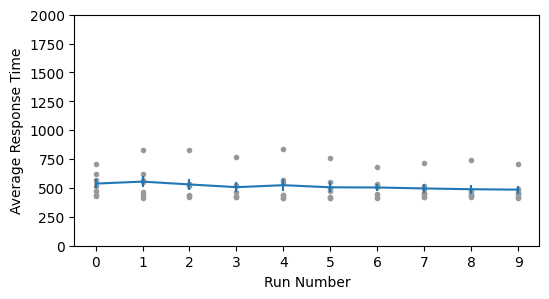

In [32]:
plot_vals = rt_by_run
meanvals = np.mean(plot_vals, axis=0)
semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
plt.figure(figsize=(6,3))
for si in range(n_subjects):
    plt.plot(np.arange(n_runs), plot_vals[si,:],'.',color=[0.6, 0.6, 0.6])
plt.errorbar(np.arange(len(meanvals)), meanvals, semvals)
plt.xticks(np.arange(n_runs))
plt.xlabel('Run Number')
plt.ylabel('Average Response Time')
ylims = [0, 2000]
plt.ylim(ylims)

In [22]:
is_natural = [np.array([1,1,0,0,1,0,0,0,0,0]).astype(bool), \
              np.array([0,0,0,1,0,0,0,1,0,1]).astype(bool)]
[super_names_eachset[cbi][is_natural[cbi]] for cbi in [0,1]], \
[super_names_eachset[cbi][~is_natural[cbi]] for cbi in [0,1]]

([array(['bird', 'body_part', 'fruit'], dtype=object),
  array(['insect', 'plant', 'vegetable'], dtype=object)],
 [array(['drink', 'electronic_device', 'home_decor', 'medical_equipment',
         'sports_equipment', 'vehicle', 'weapon'], dtype=object),
  array(['clothing', 'dessert', 'furniture', 'kitchen_tool',
         'office_supply', 'part_of_car', 'toy'], dtype=object)])

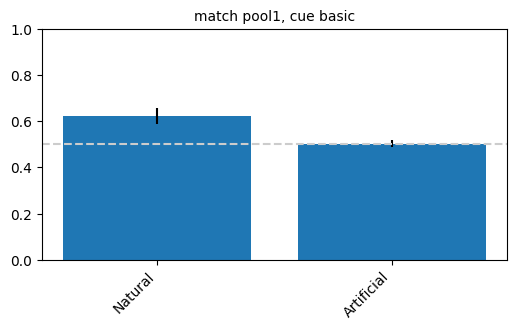

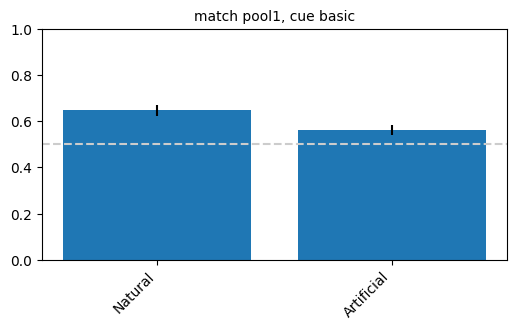

In [24]:
cc = 0; # basic
ii = 1; # pool1 (hardest)

for cbi, cb in enumerate([1,2]):

    vals = acc_by_supcat[cbi][subjects_use[subject_cb==cb],:,:,:]

    plot_vals = vals[:,cc,ii,:]
    
    # average over natural and artificial superordinate categories
    plot_vals = np.concatenate([np.mean(plot_vals[:,is_natural[cbi]==nn], axis=1, keepdims=True) \
                 for nn in [True, False]], axis=1)
    kind_names = ['Natural','Artificial']
    
    supnames = super_names_eachset[cbi]

    
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(len(meanvals)), meanvals)
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, linestyle='none', color='k')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.xticks(np.arange(len(meanvals)), kind_names, rotation=45, ha='right')
    plt.ylim([0.0, 1.0])

    plt.title('%s, %s'%(image_type_names[ii], cue_level_names[cc]))

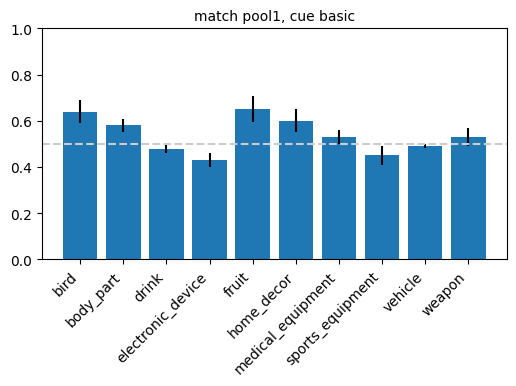

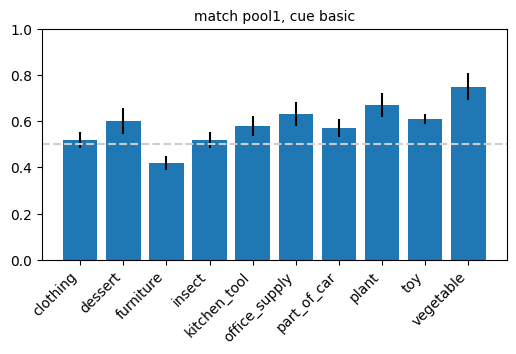

In [25]:
cc = 0; # basic
ii = 1; # pool1 (hardest)

for cbi, cb in enumerate([1,2]):

    vals = acc_by_supcat[cbi][subjects_use[subject_cb==cb],:,:,:]

    supnames = super_names_eachset[cbi]

    plot_vals = vals[:,cc,ii,:]
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(len(meanvals)), meanvals)
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, linestyle='none', color='k')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.xticks(np.arange(len(meanvals)), supnames, rotation=45, ha='right')
    plt.ylim([0.0, 1.0])

    plt.title('%s, %s'%(image_type_names[ii], cue_level_names[cc]))

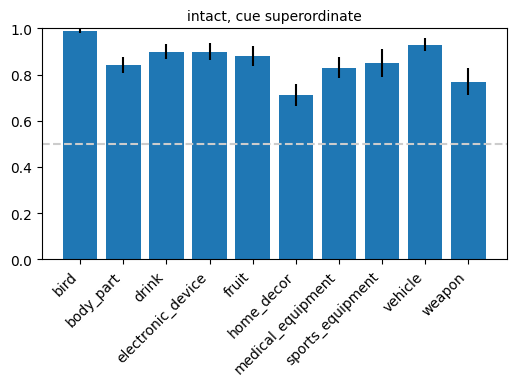

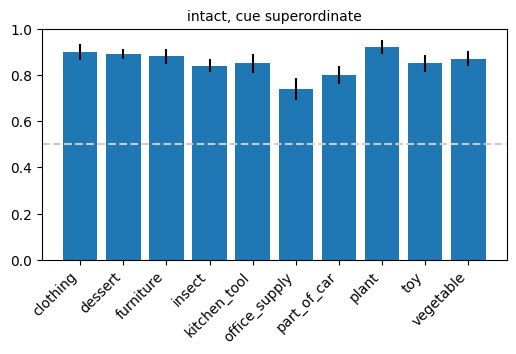

In [27]:
cc = 1;
ii = 0; 

for cbi, cb in enumerate([1,2]):

    vals = acc_by_supcat[cbi][subjects_use[subject_cb==cb],:,:,:]

    supnames = super_names_eachset[cbi]

    plot_vals = vals[:,cc,ii,:]
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])
    plt.figure(figsize=(6,3))
    plt.bar(np.arange(len(meanvals)), meanvals)
    plt.errorbar(np.arange(len(meanvals)), meanvals, semvals, linestyle='none', color='k')
    plt.axhline(0.50, color=[0.8, 0.8, 0.8], linestyle='--')
    plt.xticks(np.arange(len(meanvals)), supnames, rotation=45, ha='right')
    plt.ylim([0.0, 1.0])

    plt.title('%s, %s'%(image_type_names[ii], cue_level_names[cc]))